In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from transformers import DistilBertTokenizerFast, DistilBertModel
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from tqdm import tqdm
import json, os
from pathlib import Path
import numpy as np

In [3]:
class CommentaryTextDataset(Dataset):
    def __init__(self, clips_json_path, tokenizer, max_len=128):
        self.samples = json.load(open(clips_json_path))
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        item = self.samples[idx]

        text_path = Path(item["text"])
        with open(text_path, "r", encoding="utf-8") as f:
            text = f.read().strip()

        label = torch.tensor(item["highlight"], dtype=torch.float32)

        encoded = self.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=self.max_len,
            return_tensors="pt"
        )

        return {
            "input_ids": encoded["input_ids"].squeeze(0),
            "attention_mask": encoded["attention_mask"].squeeze(0),
            "label": label
        }

In [15]:
class DistilBertClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.bert = DistilBertModel.from_pretrained("distilbert-base-uncased")
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(768, 1)  # binary

    def forward(self, input_ids, attention_mask):
        bert_out = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled = bert_out.last_hidden_state[:, 0, :]   # CLS token
        x = self.dropout(pooled)
        return self.fc(x).squeeze(-1)

In [5]:
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

train_dataset = CommentaryTextDataset("data/data/train/clips.json", tokenizer)
val_dataset   = CommentaryTextDataset("data/data/val/clips.json", tokenizer)
test_dataset  = CommentaryTextDataset("data/data/test/clips.json", tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=16)
test_loader  = DataLoader(test_dataset, batch_size=16)

c:\Users\golde\Documents\UMD\CMSC498K - Multimodal Deep Learning\.venv\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\golde\.cache\huggingface\hub\models--distilbert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
c:\Users\golde\Documents\UMD\CMSC498K - Multimodal Deep Learning\.venv\lib\

In [9]:
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    total_correct = 0
    total = 0

    for batch in tqdm(loader, desc="Training Text", leave=False):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        optimizer.zero_grad()
        logits = model(input_ids, attention_mask)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        preds = (torch.sigmoid(logits) > 0.5).float()
        total_correct += (preds == labels).sum().item()
        total += labels.size(0)
        total_loss += loss.item() * labels.size(0)

    return total_loss / total, total_correct / total


@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    total_correct = 0
    total = 0

    for batch in loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        logits = model(input_ids, attention_mask)
        loss = criterion(logits, labels)

        preds = (torch.sigmoid(logits) > 0.5).float()
        total_correct += (preds == labels).sum().item()
        total += labels.size(0)
        total_loss += loss.item() * labels.size(0)

    return total_loss / total, total_correct / total


In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = DistilBertClassifier().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=3)

EPOCHS = 3  # BERT doesn't need many

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


In [17]:
history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

for epoch in range(1, EPOCHS+1):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)

    scheduler.step()

    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    print(f"Epoch {epoch}/{EPOCHS} | Train Loss {train_loss:.4f} | Val Loss {val_loss:.4f} | Val Acc {val_acc:.4f}")

Epoch 1/3 | Train Loss 0.4659 | Val Loss 0.4432 | Val Acc 0.8117


Epoch 2/3 | Train Loss 0.3712 | Val Loss 0.4277 | Val Acc 0.8283


Epoch 3/3 | Train Loss 0.2370 | Val Loss 0.5123 | Val Acc 0.8042


RuntimeError: Parent directory text_checkpoints does not exist.

In [ ]:
torch.save(model.state_dict(), "ckpts/text_model.pt")

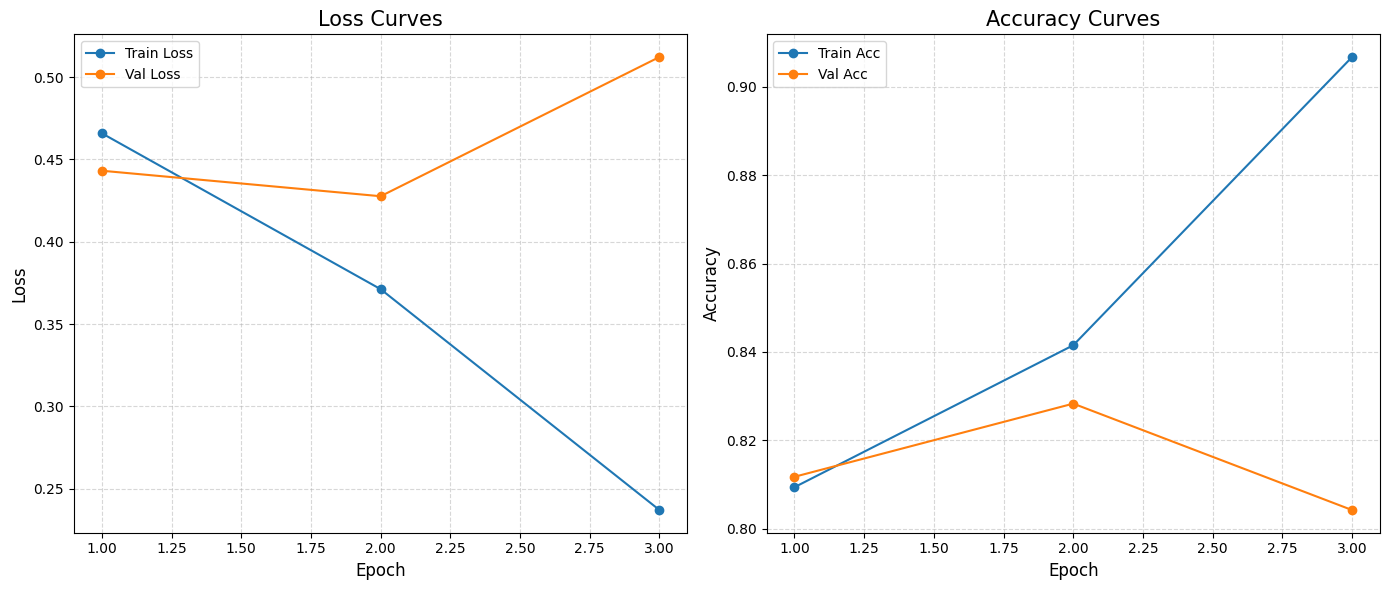

In [19]:
import matplotlib.pyplot as plt

epochs = range(1, len(history["train_loss"]) + 1)

plt.figure(figsize=(14, 6))

# ==========================
# LOSS
# ==========================
plt.subplot(1, 2, 1)
plt.plot(epochs, history["train_loss"], label="Train Loss", marker="o")
plt.plot(epochs, history["val_loss"], label="Val Loss", marker="o")
plt.title("Loss Curves", fontsize=15)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()

# ==========================
# ACCURACY
# ==========================
plt.subplot(1, 2, 2)
plt.plot(epochs, history["train_acc"], label="Train Acc", marker="o")
plt.plot(epochs, history["val_acc"], label="Val Acc", marker="o")
plt.title("Accuracy Curves", fontsize=15)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()

plt.tight_layout()
plt.show()


In [20]:
test_loss, test_acc = evaluate(model, test_loader, criterion, device)
print("===== TEXT TEST RESULTS =====")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Acc : {test_acc:.4f}")

===== TEXT TEST RESULTS =====
Test Loss: 0.5241
Test Acc : 0.8172
